In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sp
from IPython.display import Image
import time
import pickle
import os
from scipy.stats import norm

# Data Analysis final project: motion detection through image subtraction

### Ohad Michel, Ran Finkelstein and Lee Drori

## Statistical model and optimal statistics

See attached PDF, Sec. 1 for full derivation.
The resulting optimal statistic is:

$$S\left(q,\Delta q\right) = \mathcal{R}\left[\mathcal{F}^{-1}\left[F_D \hat{D} \cdot \hat{P}_D^* \cdot \hat{M}^*\left(\Delta q\right)\right]\right]$$

$$D(k) = \frac{P_r(k) N(k) - \beta P_n(k) R(k)}{\sqrt{\sigma_n^2 \left|P_r(k)\right|^2 + \beta^2 \sigma_r^2 \left|P_n(k)\right|^2}}$$

$$P_D  = \frac{F_n P_n(k) P_r(k)}{F_D\sqrt{\sigma_n^2 \left|P_r(k)\right|^2 + \beta^2 \sigma_r^2 \left|P_n(k)\right|^2}}$$

$$F_D = \frac{F_n}{\sqrt{\sigma_n^2 + \beta^2 \sigma_r^2}} $$

$$ M\left(\Delta q\right) = \exp\left(-ik\Delta q\right) - 1$$

where $\beta = \frac{F_n}{F_r}$.

## Simulate Data

In this section we define and then call the function 'Simulate' which outputs an example of data images.

The defalt parametes are:

Noise - Poisonian distributed noise with a mean of $\lambda = 300$

PSF of reference image - Gaussian with $\sigma_{P_n} = [10,5]$

PSF of new image - Gaussian with $\sigma_{P_r} = [8,4]$

Reference image position - $q = [300,300]$

movement vector pixels - $\Delta q = [0,0.8]$
 
$\beta=1.2$

$\alpha=5\cdot10^4$

##### Defining simulate data function:

In [3]:
def Simulate(Dq = None,params = None):
# Params is a list of all the defined parameters in the order they are defined in the default case.
    if Dq is None:
        Dq = 0.6 # Pixel displacement amplitude
    if params is None:
        # Define parameters
        q = [300,300] # Transient position vector
        v = np.array([0,1]) # Pixel displacement direction vector
        alpha = 5*10**4 # Flux of the Transient
        N = 512 # Image size
        Fn = 1.2 # Flux-based zero point of the new image
        Fr = 1 # Flux-based zero point of the reference image
        Lambda = 300 # Mean of the noise
        sig_Pr = [10,5] # Stdv vector of the Ref PSF
        sig_Pn = [8,4] # Stdv vector of the new PSF
        
    else:
        q = params[0] # Transient position vector
        v = params[1] # Pixel displacement direction vector
        alpha = params[2] # Flux of the Transient
        N = params[3] # Image size
        Fn = params[4] # Flux-based zero point of the new image
        Fr = params[5] # Flux-based zero point of the reference image
        Lambda = params[6] # Mean of the noise
        sig_Pr = params[7] # Stdv vector of the Ref PSF
        sig_Pn = params[8] # Stdv vector of the new PSF
    
    # Calculate from pramas
    sigma_n = np.sqrt(Lambda) # Stdv of the noise
    Dq_vec = v*Dq/np.linalg.norm(v) # Pixel displacement vector
    
    # Noise matrices
    eps_r = np.random.poisson(Lambda,(N,N)) - Lambda # zero mean Ref noise
    eps_n = np.random.poisson(Lambda,(N,N)) - Lambda # zero mean new noise

    # Create a x-y grid
    x = np.linspace(-N/2,N/2-1,N)
    xx, yy = np.meshgrid(x,x)
    normal_pdf = lambda x,y,sig_x,sig_y: np.exp(-(x**2/2/sig_x**2 + y**2/2/sig_y**2))

    # Create a kx-ky grid
    dx = x[1]-x[0]
    k = np.linspace(-np.pi/dx,np.pi/dx-2*np.pi/N,N)
    dk = k[1]-k[0]
    kx, ky = np.meshgrid(k,k)

    # Create PSF
    Pr_q = normal_pdf(xx,yy,sig_Pr[0],sig_Pr[1])
    Pr_q = Pr_q/np.sum(Pr_q)

    Pn_q = normal_pdf(xx,yy,sig_Pn[0],sig_Pn[1])
    Pn_q = Pn_q/np.sum(Pn_q)

    # Create transient source image
    delta = np.zeros_like(Pr_q)
    delta[q[0],q[1]] = 1

    # Create Ref image
    R_k = alpha*Fr*np.fft.fftshift(np.fft.fft2(delta))*np.fft.fftshift(np.fft.fft2(Pr_q))
    R_q = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(R_k)))) + eps_r

    # Create new image
    N_k = alpha*Fn*np.fft.fftshift(np.fft.fft2(delta))*np.fft.fftshift(np.fft.fft2(Pn_q))*np.exp(-1j*(kx*Dq_vec[0] + ky*Dq_vec[1]))
    N_q = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(N_k)))) + eps_n

    return N_q,R_q,Pn_q,Pr_q,q,sigma_n,N

##### Call the function:

In [4]:
N_q,R_q,Pn_q,Pr_q,q,sigma_n,N = Simulate(0.8)
N_q0 = Simulate(0)[0]
# N_q,R_q,Pn_q,Pr_q,q,sigma_n,N = Simulate(0.8,[[300,300],np.array([0,1]),5*10**4,512,1.8,1,300,[10,5],[8,4]])

##### Save Data to file:

In [5]:
# Save Data
with open(r'Simulated Data\Temp\Data.pickle', 'w') as f:
    pickle.dump([N_q,R_q,Pn_q,Pr_q,q,sigma_n,N_q0,N], f)

##### Load Data file:

In [6]:
# Load Data
with open(r'Simulated Data\Temp\Data.pickle') as f:
    N_q,R_q,Pn_q,Pr_q,q,sigma_n,N_q0,N = pickle.load(f)

##### Plot Data:

<IPython.core.display.Javascript object>


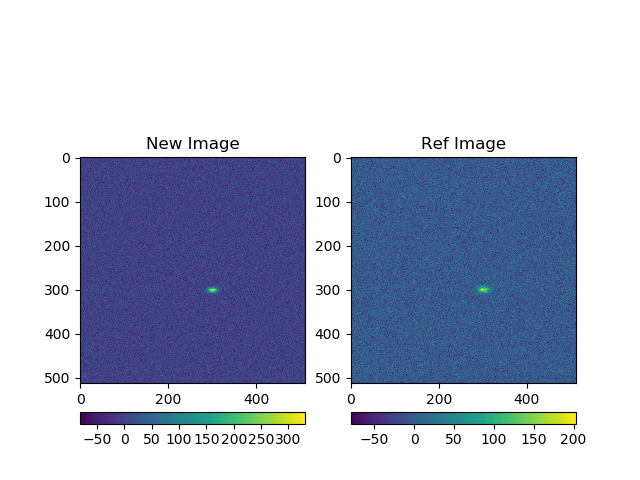

In [7]:
# Plot Data
plt.figure()
plt.subplot(1,2,1)
imNq = plt.imshow(N_q)
plt.title('New Image')
plt.colorbar(imNq, orientation="horizontal", fraction=0.04, pad=0.08)

plt.subplot(1,2,2)
imRq = plt.imshow(R_q)
plt.title('Ref Image')
plt.colorbar(imRq, orientation="horizontal", fraction=0.04, pad=0.08)

## Calculating expected preformance

We derived the anlytical expression for the variance of $S(q|H_0)$ see PDF section 2, the result is:

$$Var\left[S(q,\Delta q|H_0)\right] \equiv \sigma_s^2 = \frac{F_n^2}{\pi\sigma_n^4} \Rightarrow \sigma_s = \frac{F_n}{\sqrt{\pi}\sigma_n^2}$$

We can compute the false positive probability for any $\eta$, for example we computed for $\eta = 5\sigma_s$:

In [8]:
Fn = 1.2
sigma_s = Fn/(np.sqrt(np.pi)*sigma_n**2)
eta = 5*sigma_s
CL = norm.cdf(eta, loc=0, scale=sigma_s) # Find the cdf of normal distribution with mean 'loc' and stdv 'scale'

print 'The theoretical false positive prob. is %.3g' %(N**2*(1-CL))

The theoretical false positive prob. is 0.0751


## Programing the statistics:

###### *This version supports only 1D movements, y direction in this case. 

 We first move all the data to fourier space:

In [9]:
# Move to k-space
sigma_r = sigma_n # Noise Stdv is the same for both images
N_k = np.fft.fftshift(np.fft.fft2(N_q))
N_k0 = np.fft.fftshift(np.fft.fft2(N_q0))
R_k = np.fft.fftshift(np.fft.fft2(R_q))
Pn_k = np.fft.fftshift(np.fft.fft2(Pn_q))
Pr_k = np.fft.fftshift(np.fft.fft2(Pr_q))

### Computing  Log Likelihood ratio

We start by computing everything for zero movement images in order to verify that without motion there are no distinict features in $D(q|H_0)$ and that the STD of $S(q,\Delta q|H_0)$ is similar to the expected result from the previous section. Next we repeat the calculation for the actual finite movement data.

### For zero movement:

We start by finding the proper substruction image $D(q)$.
For that we find $\beta$ such that the RMS of $D(q)$ is minimized:

In [10]:
def minfunc0(beta):
    D_k0 = (Pr_k*N_k0 - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)
    D_q0 = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k0))))
    return np.sqrt(np.mean(np.square(D_q0)))

In [11]:
betaOpt0 = sp.fmin(minfunc0, x0 = 2)
print "Beta = %r" %betaOpt0

Optimization terminated successfully.
         Current function value: 1.002067
         Iterations: 16
         Function evaluations: 32
Beta = array([1.17236328])


##### Ploting $D(q|H_0)$:

<IPython.core.display.Javascript object>


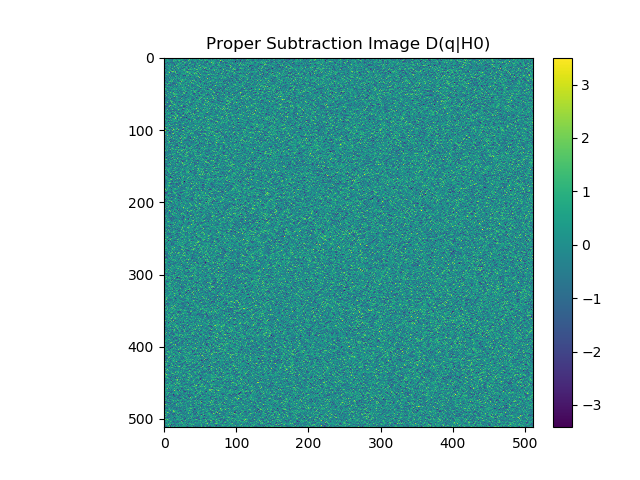

In [12]:
D_k0 = lambda beta: (Pr_k*N_k0 - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) 
                                                      + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)

D_q0 = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k0(betaOpt0)))))

plt.figure()
imDq = plt.imshow(D_q0)
plt.title('Proper Subtraction Image D(q|H0)')
plt.colorbar(imDq, fraction=0.046, pad=0.04)

Now we calculate $S(q,\Delta q|H_0)$ for different shifts ($dq$) and return the maximal pixel of each image.

In [13]:
Fn = 1.2 # New flux
FD = lambda beta: Fn/np.sqrt(sigma_n**2 + beta**2*sigma_r**2) # Difference image PSF normalization
PD_k = lambda beta: Fn*Pr_k*Pn_k/(FD(beta)*np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)) # Difference image PSF 

# Create M matrix
k = np.linspace(-np.pi,np.pi-2*np.pi/N,N)
kx, ky = np.meshgrid(k,k)
dq = np.arange(-30,30,0.4)

i = 0
S0 = np.zeros((len(dq),N,N))
for l in dq:
    
    M = np.exp(-1j*(kx*0 + ky*l))-1
    S_q = lambda beta: np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(FD(beta)*D_k0(beta)*PD_k(beta).conj()*M.conj()))))
    S0[i] = S_q(betaOpt0)
    i = i+1

<IPython.core.display.Javascript object>


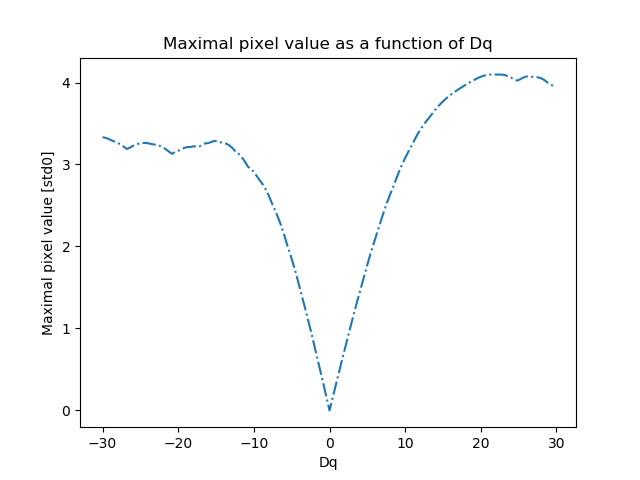

max = 4.099184554134975
Dq = 22.399999999999814


In [14]:
S0max = np.amax(np.amax(S0,axis=1), axis=1) # Vector of maximal pixel value for each dq
std0 = np.std(S0[np.argmax(S0max),:,:]) # Stdev of the S0 image with maximal pixel value 
S0max = S0max/std0 # normlization
plt.figure()
plt.plot(dq,S0max,'-.')
plt.xlabel('Dq')
plt.ylabel('Maximal pixel value [std0]')
plt.title('Maximal pixel value as a function of Dq')
print 'max = %r' %np.max(S0max)
print 'Dq = %r' %dq[np.argmax(S0max)]

##### Ploting $S(q,\Delta q|H_0)$:

<IPython.core.display.Javascript object>


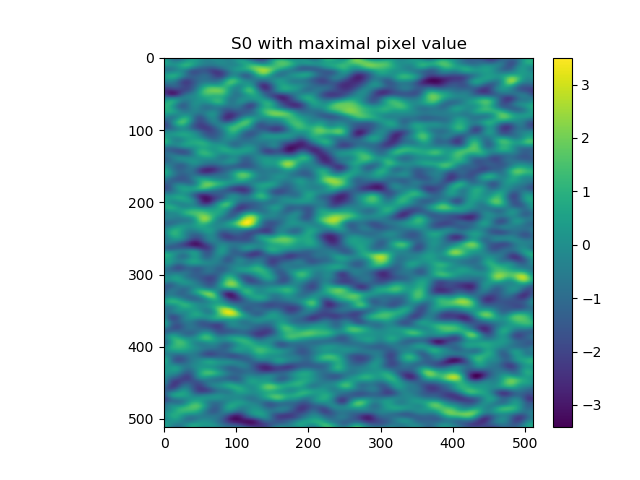

Text(0.5,1,'S0 with maximal pixel value')

In [15]:
# Show the maximal S0 image
plt.figure()
plt.imshow(S0[np.argmax(S0max),:,:])
plt.colorbar(imDq, fraction=0.046, pad=0.04)
plt.title('S0 with maximal pixel value')

### For finite movement

Now we repeat everything for the finite movement data:

In [16]:
def minfunc(beta):
    D_k = (Pr_k*N_k - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)
    D_q = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k))))
    return np.sqrt(np.mean(np.square(D_q)))

In [17]:
betaOpt = sp.fmin(minfunc, x0 = 2)
print "Beta = %r" %betaOpt

Optimization terminated successfully.
         Current function value: 1.000318
         Iterations: 16
         Function evaluations: 32
Beta = array([1.16572266])


##### Ploting $D(q|H_1)$:

<IPython.core.display.Javascript object>


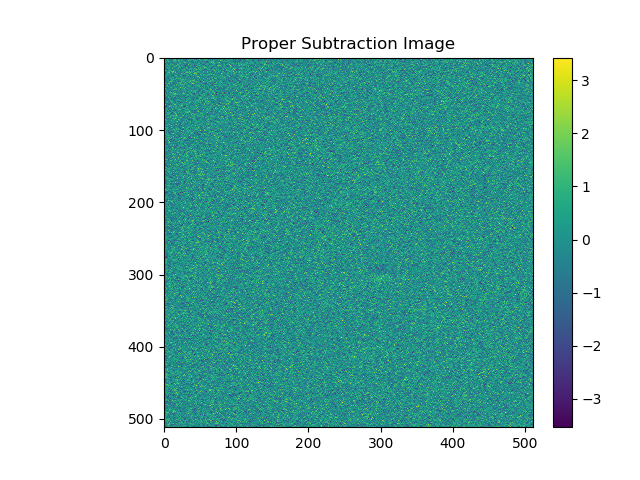

In [18]:
D_k = lambda beta: (Pr_k*N_k - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) 
                                                      + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)

D_q = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k(betaOpt)))))

plt.figure()
imDq = plt.imshow(D_q)
plt.title('Proper Subtraction Image')
plt.colorbar(imDq, fraction=0.046, pad=0.04)

In [19]:
Fn = 1.2 # New flux
FD = lambda beta: Fn/np.sqrt(sigma_n**2 + beta**2*sigma_r**2) # Difference image PSF normalization
PD_k = lambda beta: Fn*Pr_k*Pn_k/(FD(beta)*np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)) # Difference image PSF 

# Create M matrix
k = np.linspace(-np.pi,np.pi-2*np.pi/N,N)
kx, ky = np.meshgrid(k,k)
dq = np.arange(-30,30,0.4)

i = 0
S = np.zeros((len(dq),N,N))
for l in dq:
    
    M = np.exp(-1j*(kx*0 + ky*l))-1
    Mb = np.exp(-1j*(kx*0 + ky*l))

    S_q = lambda beta: np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(FD(beta)*D_k(beta)*PD_k(beta).conj()*M.conj()))))
    S[i] = S_q(betaOpt)
    i = i+1

<IPython.core.display.Javascript object>


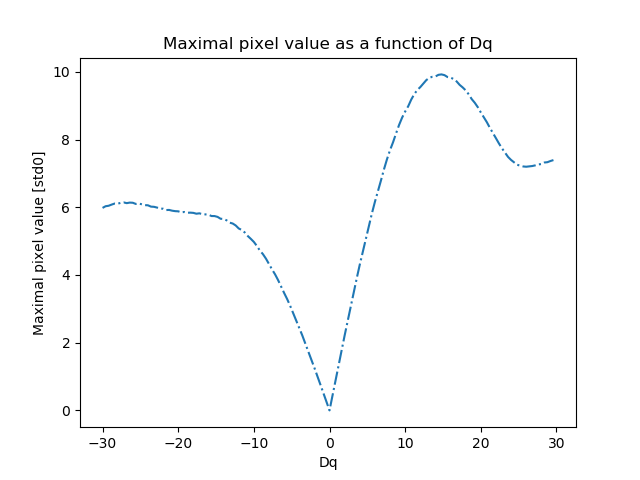

max = 9.9229817867795
Dq = 14.79999999999984


In [20]:
Smax = np.amax(np.amax(S,axis=1), axis=1)/std0
plt.figure()
plt.plot(dq,Smax,'-.')
plt.xlabel('Dq')
plt.ylabel('Maximal pixel value [std0]')
plt.title('Maximal pixel value as a function of Dq')
print 'max = %r' %np.max(Smax)
print 'Dq = %r' %dq[np.argmax(Smax)]

##### Ploting $S(q,\Delta q|H_1)$:

<IPython.core.display.Javascript object>


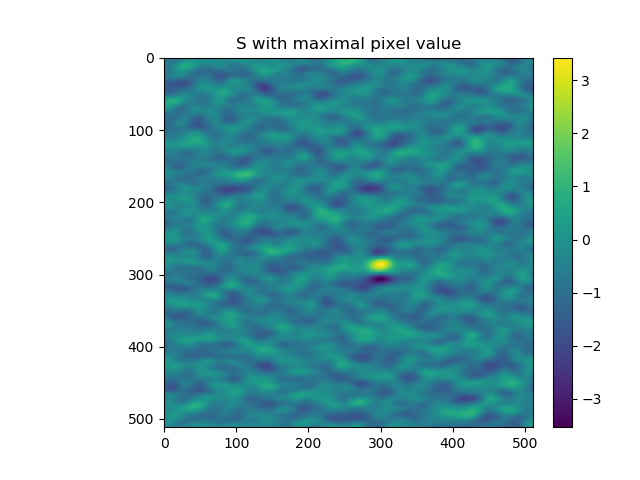

Text(0.5,1,'S with maximal pixel value')

In [21]:
# Show the maximal S image
plt.figure()
plt.imshow(S[np.argmax(S0max),:,:])
plt.colorbar(imDq, fraction=0.046, pad=0.04)
plt.title('S with maximal pixel value')

## Verifying the expected preformance

First we notice that the STD of S0 agrees well with the theory:

In [22]:
print 'The theoretical value was %.3g and the numerical value is %.3g' %(std0,sigma_s)

The theoretical value was 0.00283 and the numerical value is 0.00226


To verify the expected preformance we ran the 'Simulate' function 100 times for the same parameters (using Simulate_Set notebook) and analyzed all the data (using Analyze_Set notebook), The results for 0.4 pixel movement and 0.8 pixel movement are shown below:

<IPython.core.display.Javascript object>


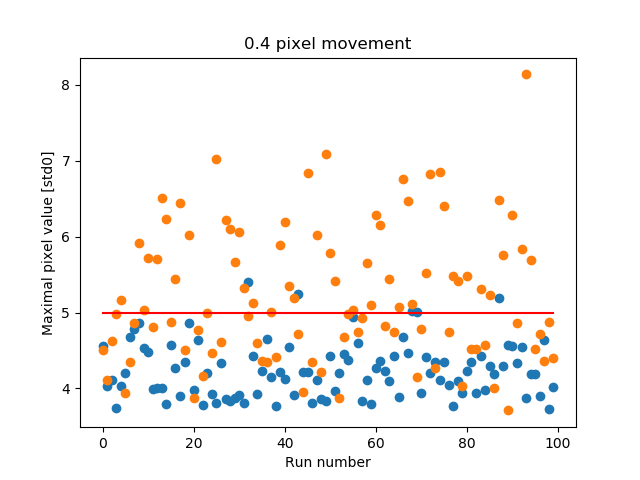

Number of successful detections = 52
Successful detections fraction = 0.52
--------------------------------------
Number of false positives = 5
false positive fraction = 0.05


<IPython.core.display.Javascript object>


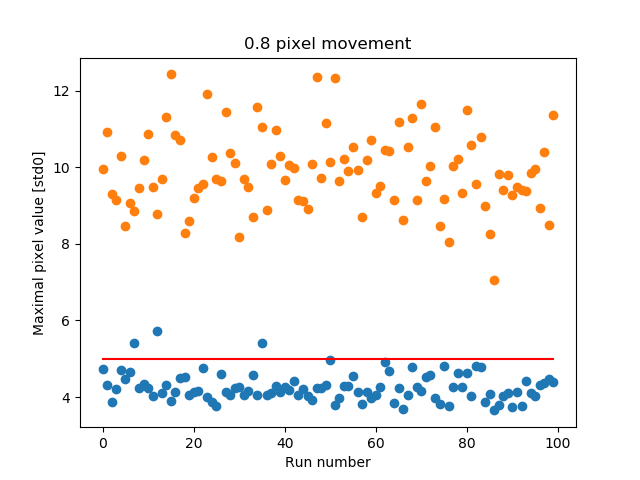

Number of successful detections = 100
Successful detections fraction = 1.0
--------------------------------------
Number of false positives = 3
false positive fraction = 0.03


In [23]:
eta = 5 # Define detection threshold
for i in range(2):
    if i:
        with open(r'Simulated Data\Movment of +0.8 in y set\results1.pickle') as f:
            ZeroMove_max,FiniteMove_max = pickle.load(f)
    else:
        with open(r'Simulated Data\Movment of +0.4 in y set2\results1.pickle') as f:
            ZeroMove_max,FiniteMove_max = pickle.load(f)
    
    plt.figure()
    plt.plot(ZeroMove_max,'o')
    plt.plot(FiniteMove_max,'o')
    plt.plot(eta*(np.ones(len(FiniteMove_max))),'r')
    plt.xlabel('Run number')
    plt.ylabel('Maximal pixel value [std0]')
    if i:
        plt.title('0.8 pixel movement')
    else:
        plt.title('0.4 pixel movement')
    

    print 'Number of successful detections = %r' %np.sum(FiniteMove_max>eta)
    print 'Successful detections fraction = %r' %(np.sum(FiniteMove_max>eta)/float(len(FiniteMove_max)))

    print '--------------------------------------'

    print 'Number of false positives = %r' %np.sum(ZeroMove_max>eta)
    print 'false positive fraction = %r' %(np.sum(ZeroMove_max>eta)/float(len(ZeroMove_max)))

We can see that for larger displacements we get a better separation between the two hypothesis, such that we can rule out the null hypothesis with minimal false positive rates and high detection rate. The false positive fraction agrees to a good extent with our expected perfromance (0.0751, see above). With larger data sets, we expect that this results would converge closer to our predictions.